In [3]:
import os
import copy
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ski_ssim
from tqdm.auto import tqdm
from typing import Dict, Optional, Callable

import torch
from pytorch_msssim import SSIM
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torchvision import transforms

# Setup device to GPU if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

SEED = 42
DATASET = Path(r"C:\Users\user\Desktop\mvtec_anomaly_detection\capsule")       # Selected dataset from "data/" directory
NUM_WORKERS = os.cpu_count()
IMG_RESIZE = 256            # Resize of an input images
INPUT_CROP  = 256           # Crop of resized images (when equal to IMG_RESIZE value, there is no crop applied)
TRAINING_SIZE = 1000        # Number of images used for training
TEST_SIZE = 100             # Number of images used for testing

NUM_EPOCHS = 200
BATCH_SIZE = 32
BASE_LEARNING_RATE = 1e-2
SCH_PATIENCE = 10
SCH_FACTOR = 0.5

train_dir = DATASET / "train"
test_dir  = DATASET / "test"

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # If running on the CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

def explore_dir(dir_path: Path) -> None:
    """
    Function for exploring specified directory dependencies and number of images
    
    Args:
        dir_path (str or Path): Location of interested directory   
    """
    for current_dir, dirs, img in os.walk(dir_path):
        print(f"'{current_dir}' have {len(dirs)} directories and {len(img)} images.")
    print("")

explore_dir(train_dir)
explore_dir(test_dir)

D:\anaconda\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\train' have 1 directories and 0 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\train\good' have 0 directories and 219 images.

'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test' have 6 directories and 0 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\crack' have 0 directories and 23 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\faulty_imprint' have 0 directories and 22 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\good' have 0 directories and 23 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\poke' have 0 directories and 21 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\scratch' have 0 directories and 23 images.
'C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\squeeze' have 0 directories and 20 images.



Random image path: C:\Users\user\Desktop\mvtec_anomaly_detection\capsule\test\crack\016.png
Image size: 1000x1000


(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

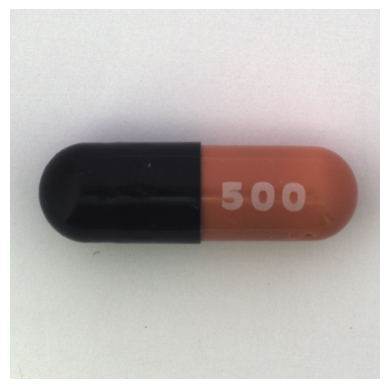

In [4]:
images_paths = list(test_dir.glob("*/*.png"))
random_image_path = random.choice(images_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image size: {img.height}x{img.width}") 

plt.imshow(img)
plt.axis("off")

In [3]:
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

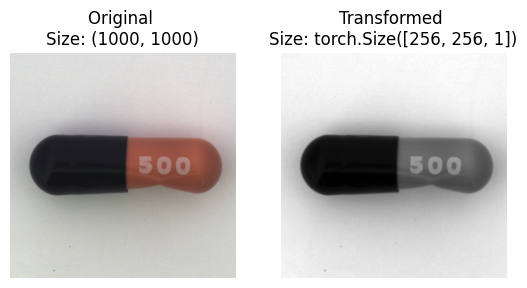

In [4]:
def image_transformation_plot(image_path: str, transform: transforms.Compose) -> None:
    """
    Plots and compares selected image before and after transformation.
    
    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    transformed_image = transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, data_transform)

In [5]:
def random_crop(data_dir: Path, N: int, crop: int) -> TensorDataset:
    """
    Function for building a dataset with randomly chosen images with applied random crops to size.
    
    Args:
        data_dir (str or Path): Location of the directory containing images.
        N (int): Number of images in the prepared dataset.
        crop (int): Size of the crop (crop, crop).
        
    Returns:
        output_dataset (list): A list of cropped images
    """

    crop_size = (crop, crop)
    output_dataset = []
    images_paths = list(data_dir.glob("good/*.png"))

    if not images_paths:
        raise ValueError(f"No images found in directory: {data_dir}/good")

    if crop > IMG_RESIZE:
        raise ValueError(f"Crop size {crop} is larger than desired image size {IMG_RESIZE}.")
  
    for i in range(0, N):
        random_image_path = random.choice(images_paths)
        img = Image.open(random_image_path)
        img = data_transform(img).squeeze(0)
        
        x_start = random.randint(0, img.shape[0]-crop_size[0])
        y_start = random.randint(0, img.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        
        crop = img[x_start:x_end, y_start:y_end]
        crop = crop.type(torch.float32).unsqueeze(0)
        output_dataset.append(crop)

        return torch.stack(output_dataset)


In [6]:
train_data = random_crop(data_dir=train_dir, N=TRAINING_SIZE, crop = INPUT_CROP)
test_data = random_crop(data_dir=test_dir, N=TEST_SIZE, crop = INPUT_CROP)

print(f"Image tensor:\n{test_data[0][0]}")
print(f"Image shape: {test_data[0][0].shape}")
print(f"Image datatype: {test_data[0][0].dtype}")

Image tensor:
tensor([[0.8627, 0.8627, 0.8784,  ..., 0.8706, 0.8784, 0.8706],
        [0.8667, 0.8667, 0.8745,  ..., 0.8745, 0.8784, 0.8745],
        [0.8667, 0.8667, 0.8706,  ..., 0.8784, 0.8784, 0.8706],
        ...,
        [0.8157, 0.8157, 0.8157,  ..., 0.8392, 0.8471, 0.8510],
        [0.8196, 0.8118, 0.8157,  ..., 0.7961, 0.8471, 0.8627],
        [0.8235, 0.8196, 0.8196,  ..., 0.7647, 0.8431, 0.8588]])
Image shape: torch.Size([256, 256])
Image datatype: torch.float32


In [7]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

# Check if the input values are in <0,1> range to define activation function or normalize
images = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

Image shape: torch.Size([1, 1, 256, 256])
 0.07058823853731155
 0.8705882430076599


In [8]:
class autoencoder_v0(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 500, 3, stride=1, padding=0)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(500, 128, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
     
model = autoencoder_v0()

summary(model, input_size=[BATCH_SIZE, 1, INPUT_CROP, INPUT_CROP])

Layer (type:depth-idx)                   Output Shape              Param #
autoencoder_v0                           [32, 1, 256, 256]         --
├─Sequential: 1-1                        [32, 500, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        544
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          32,832
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 128, 32, 32]         131,200
│    └─ReLU: 2-6                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-7                       [32, 64, 16, 16]          131,136
│    └─ReLU: 2-8                         [32, 64, 16, 16]          --
│    └─Conv2d: 2-9                       [32, 128, 8, 8]           131,200
│    └─ReLU: 2-10                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [32, 500, 6, 6]         

In [9]:
def train_step(model: nn.Module, 
               dataloader: DataLoader, 
               loss_fn: SSIM, 
               optimizer) -> float:
    
    model.train()
    train_loss = 0
        
    for batch, img in enumerate(dataloader):
        
        img = img.to(device)
        recon = model(img)
        loss = 1 - loss_fn(recon, img)
        train_loss += loss.item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    
    return train_loss

In [10]:
def test_step(model: nn.Module, 
              dataloader: DataLoader, 
              loss_fn: SSIM, 
              epoch: int) -> float:
    
    model.eval()
    test_loss = 0
    
    with torch.inference_mode():
        for batch, img in enumerate(dataloader):

            img = img.to(device)
            recon = model(img)
            loss = 1 - loss_fn(recon, img)
            test_loss += loss.item() 
    
        test_loss = test_loss / len(dataloader)
    
    return test_loss

In [11]:
def train(model: nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer, 
          loss_fn: SSIM, 
          epochs: int) -> Dict[str, list]:
    """
    Running train and test steps, plotting training progress and loss values.
    
    Args:
        model: Autoencoder model instance
        train_dataloader: Dataloader with training images
        test_dataloader: Dataloader with test images
        optimizer: Used optimizer - SSIM or MSE
        loss_fn: Used loss function
        epochs: Number of epochs to train the model
        
    Returns:
        results (dict): A dictionary with calculated loss values
    """
    results = {"train_loss": [], "test_loss": []}
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=SCH_PATIENCE, factor=SCH_FACTOR)
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)
        
        # Update learning rate if needed
        scheduler.step(test_loss)
        if test_loss < best_loss:
            best_loss = test_loss
            best_weights = copy.deepcopy(model.state_dict())

        train_ssim = (1 - train_loss)*100
        test_ssim = (1 - test_loss)*100
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"train_ssim: {train_ssim:.2f}% | "
                f"test_ssim: {test_ssim:.2f}% | ")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    model.load_state_dict(best_weights)

    return results

In [12]:
criterion = SSIM(win_sigma=1.5, data_range=1, size_average=True, channel=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=BASE_LEARNING_RATE)

In [13]:
model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=criterion, 
                      epochs=NUM_EPOCHS)

  0%|          | 1/200 [00:17<56:31, 17.04s/it]

Epoch: 1 | train_loss: 0.2824 | test_loss: 0.9967 | train_ssim: 71.76% | test_ssim: 0.33% | 


  6%|▌         | 11/200 [03:10<54:26, 17.28s/it]

Epoch: 11 | train_loss: 0.2655 | test_loss: 0.2754 | train_ssim: 73.45% | test_ssim: 72.46% | 


 10%|█         | 21/200 [06:05<51:46, 17.35s/it]

Epoch: 21 | train_loss: 0.2546 | test_loss: 0.2636 | train_ssim: 74.54% | test_ssim: 73.64% | 


 16%|█▌        | 31/200 [08:56<48:12, 17.11s/it]

Epoch: 31 | train_loss: 0.2456 | test_loss: 0.2543 | train_ssim: 75.44% | test_ssim: 74.57% | 


 20%|██        | 41/200 [11:51<46:23, 17.50s/it]

Epoch: 41 | train_loss: 0.2386 | test_loss: 0.2471 | train_ssim: 76.14% | test_ssim: 75.29% | 


 26%|██▌       | 51/200 [14:43<42:12, 16.99s/it]

Epoch: 51 | train_loss: 0.2335 | test_loss: 0.2416 | train_ssim: 76.65% | test_ssim: 75.84% | 


 30%|███       | 61/200 [17:35<39:42, 17.14s/it]

Epoch: 61 | train_loss: 0.2293 | test_loss: 0.2373 | train_ssim: 77.07% | test_ssim: 76.27% | 


 36%|███▌      | 71/200 [20:25<36:28, 16.97s/it]

Epoch: 71 | train_loss: 0.2257 | test_loss: 0.2341 | train_ssim: 77.43% | test_ssim: 76.59% | 


 40%|████      | 81/200 [23:16<33:48, 17.05s/it]

Epoch: 81 | train_loss: 0.2175 | test_loss: 0.2253 | train_ssim: 78.25% | test_ssim: 77.47% | 


 46%|████▌     | 91/200 [26:05<31:02, 17.09s/it]

Epoch: 91 | train_loss: 0.1812 | test_loss: 0.1835 | train_ssim: 81.88% | test_ssim: 81.65% | 


 50%|█████     | 101/200 [28:58<28:29, 17.27s/it]

Epoch: 101 | train_loss: 0.1508 | test_loss: 0.1577 | train_ssim: 84.92% | test_ssim: 84.23% | 


 56%|█████▌    | 111/200 [31:49<25:25, 17.15s/it]

Epoch: 111 | train_loss: 0.1277 | test_loss: 0.1385 | train_ssim: 87.23% | test_ssim: 86.15% | 


 60%|██████    | 121/200 [34:39<22:25, 17.03s/it]

Epoch: 121 | train_loss: 0.1181 | test_loss: 0.1293 | train_ssim: 88.19% | test_ssim: 87.07% | 


 66%|██████▌   | 131/200 [37:31<19:52, 17.29s/it]

Epoch: 131 | train_loss: 0.1156 | test_loss: 0.1314 | train_ssim: 88.44% | test_ssim: 86.86% | 


 70%|███████   | 141/200 [40:23<16:57, 17.25s/it]

Epoch: 141 | train_loss: 0.1139 | test_loss: 0.1240 | train_ssim: 88.61% | test_ssim: 87.60% | 


 76%|███████▌  | 151/200 [43:15<14:02, 17.20s/it]

Epoch: 151 | train_loss: 0.1063 | test_loss: 0.1182 | train_ssim: 89.37% | test_ssim: 88.18% | 


 80%|████████  | 161/200 [46:06<11:05, 17.06s/it]

Epoch: 161 | train_loss: 0.1033 | test_loss: 0.1161 | train_ssim: 89.67% | test_ssim: 88.39% | 


 86%|████████▌ | 171/200 [48:57<08:15, 17.10s/it]

Epoch: 171 | train_loss: 0.1006 | test_loss: 0.1138 | train_ssim: 89.94% | test_ssim: 88.62% | 


 90%|█████████ | 181/200 [51:48<05:29, 17.33s/it]

Epoch: 181 | train_loss: 0.0986 | test_loss: 0.1122 | train_ssim: 90.14% | test_ssim: 88.78% | 


 96%|█████████▌| 191/200 [54:39<02:33, 17.05s/it]

Epoch: 191 | train_loss: 0.0975 | test_loss: 0.1105 | train_ssim: 90.25% | test_ssim: 88.95% | 


100%|██████████| 200/200 [57:13<00:00, 17.17s/it]


Text(0, 0.5, 'Loss')

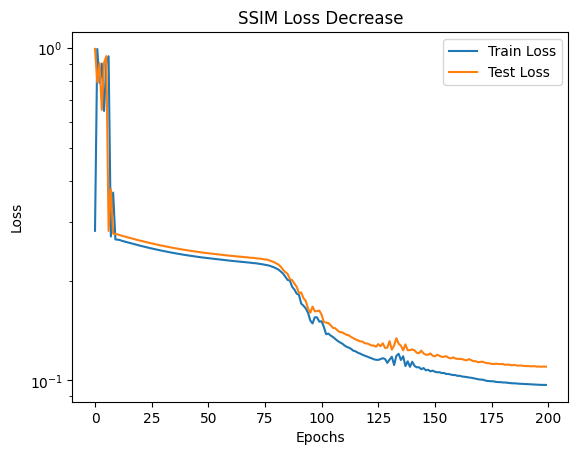

In [14]:
ax = pd.DataFrame({
    'Train Loss': [loss for loss in model_results['train_loss']],
    'Test Loss': [loss for loss in model_results['test_loss']]
}).plot(title='SSIM Loss Decrease', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [34]:
def load_model(model_name: str):
    """
    Function for loading saved models parameters.
    
    Args:
        model_name (str): Name of the model to load
        
    Returns:
        loaded_model: A model instance with loaded parameters
    """
    model_path = Path(r"C:\Users\user\Desktop\mvtec_anomaly_detection\models")
    model_save_path = model_path / model_name

    loaded_model = autoencoder_v0()
    loaded_model.load_state_dict(torch.load(f=model_save_path))

    loaded_model = loaded_model.to(device)
    
    return loaded_model
MODEL_NAME = "capsule_500x6x6_bottleneck_97_5acc.pth"
model_loaded = load_model(MODEL_NAME)


In [29]:
# Data transform block to fit input image if the training was done on cropped images.
data_transform_test = transforms.Compose([
    transforms.Resize(size=(INPUT_CROP, INPUT_CROP)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [28]:
def visualize_ssim(model: torch.nn.Module, 
                   image_path: str,  
                   transform: Optional[Callable] = None,
                   device: torch.device = device) -> None:
    """
    Plots the original image, the reconstructed image, and the SSIM heatmap.

    Args:
        model (torch.nn.Module): The autoencoder model.
        image_path (str): Path to the image file.
        transform (Optional[Callable]): Optional transformation to apply to the image before reconstruction.
        device (torch.device): Device on which to run the model (CPU or GPU).

    Returns:
        None
    """

    # Load and transform image
    img = Image.open(image_path)
    img_transformed = transform(img) if transform else transforms.ToTensor()(img)

    model.to(device)
    model.eval()

    with torch.inference_mode():
        input_image = img_transformed.unsqueeze(0).to(device)  # Add batch dim
        reconstructed = model(input_image)

    # Convert tensors to CPU numpy arrays for visualization
    original = img_transformed.permute(1, 2, 0).cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # If image is single-channel, squeeze last dim
    if original.shape[2] == 1:
        original = original.squeeze(2)
        reconstructed = reconstructed.squeeze(2)

    # Compute SSIM map
    _, ssim_map = ski_ssim(original, reconstructed, full=True, data_range=1)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title(Path(image_path).stem.capitalize())
    ax[0].axis("off")
    
    ax[1].imshow(reconstructed, cmap='gray')
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")
    
    ax[2].imshow(1 - ssim_map, cmap='jet', vmin=0, vmax=1)
    ax[2].set_title("SSIM Map (1-SSIM)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


In [26]:
model_path = Path(r"C:\Users\user\Desktop\mvtec_anomaly_detection\models")
model_path.mkdir(parents=True, exist_ok=True)  

model_name = "capsule_500x6x6_bottleneck_97_5acc.pth"
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")

# 儲存模型
torch.save(obj=model.state_dict(), f=model_save_path)

Saving model to: C:\Users\user\Desktop\mvtec_anomaly_detection\models\capsule_500x6x6_bottleneck_97_5acc.pth
